# 트위터 API로 연관 키워드 분석하기

### 바로가기

- [<Step1. API 호출> : 트위터 API로 데이터 가져오기](#<Step1.-API-호출>-:-트위터-API로-데이터-가져오기)
    - [API 데이터로 데이터 프레임 생성하기]
- [<Step2. 추출> : 키워드 추출](#<Step2.-추출>-:-키워드-추출)
    - [텍스트 데이터 전처리]
    - [nltk, konlpy를 이용한 키워드 추출]
- [<Step3. 분석> : 연관 분석을 이용한 키워드 분석](#<Step3.-분석>-:-연관-분석을-이용한-키워드-분석)
    - [연관 키워드 추출하기]
    - [단어 빈도 추출하기]
- [<Step4. 시각화> : 연관 키워드 네트워크 시각화](#<Step4.-시각화>-:-연관-키워드-네트워크-시각화)
    - [연관 키워드 네트워크 시각화]

-----

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# <Step1. API 호출> : 트위터 API로 데이터 가져오기

-----

##### 트위터 API 가져오기

In [11]:
import tweepy

api_key = "RvnZeIl8ra88reu8fm23m0bST"
api_secret = "wTRylK94GK2KmhZUnqXonDaIszwAsS6VPvpSsIo6EX5GQLtzQo"
access_token = "959614462004117506-dkWyZaO8Bz3ZXh73rspWfc1sQz0EnDU"
access_token_secret = "rxDWfg7uz1yXMTDwijz0x90yWhDAnmOM15R6IgC8kmtTe"

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)

# twitter API를 사용하기 위한 준비입니다.
api = tweepy.API(auth)

In [12]:
# 크롤링된 데이터를 저장할 데이터 프레임입니다.
columns = ['created', 'tweet_text']
df = pd.DataFrame(columns=columns)

keyword='코로나'

# twitter API를 사용하여 ‘코로나’이 포함된 100페이지의 트윗들을 크롤링한 뒤, ‘text’, ‘created_at’ 정보를 데이터 프레임으로 저장합니다.
for i in range(1,100):
    print("Get data", str(i/500*100), "% complete..")
    tweets = api.search(keyword)
    for tweet in tweets:
        tweet_text = tweet.text
        created = tweet.created_at
        row = [created, tweet_text]
        series = pd.Series(row, index=df.columns)
        df = df.append(series, ignore_index=True)
print("Get data 100 % complete..")

Get data 0.2 % complete..
Get data 0.4 % complete..
Get data 0.6 % complete..
Get data 0.8 % complete..
Get data 1.0 % complete..
Get data 1.2 % complete..
Get data 1.4000000000000001 % complete..
Get data 1.6 % complete..
Get data 1.7999999999999998 % complete..
Get data 2.0 % complete..
Get data 2.1999999999999997 % complete..
Get data 2.4 % complete..
Get data 2.6 % complete..
Get data 2.8000000000000003 % complete..
Get data 3.0 % complete..
Get data 3.2 % complete..
Get data 3.4000000000000004 % complete..
Get data 3.5999999999999996 % complete..
Get data 3.8 % complete..
Get data 4.0 % complete..
Get data 4.2 % complete..
Get data 4.3999999999999995 % complete..
Get data 4.6 % complete..
Get data 4.8 % complete..
Get data 5.0 % complete..
Get data 5.2 % complete..
Get data 5.4 % complete..
Get data 5.6000000000000005 % complete..
Get data 5.800000000000001 % complete..
Get data 6.0 % complete..
Get data 6.2 % complete..
Get data 6.4 % complete..
Get data 6.6000000000000005 % comp

In [13]:
df.to_csv("tweet_temp.csv", index=False)

# <Step2. 추출> : 키워드 추출

### [텍스트 데이터 전처리]

In [14]:
df = pd.read_csv("../data/tweet_temp.csv")
df.head()

,created,tweet_text
0,2020-10-29 06:19:32,호게임산악회 헬로바카라 강남맛집 일본여행 볼보 광주맛집 테슬라 인스타패션 ❤문의 라...
1,2020-10-29 06:19:31,RT @Chateau_Margaux: '스스로 코로나 두 번 감염' 69세 교수의 ...
2,2020-10-29 06:19:27,RT @longforjustice: 코로나 의도적으로 두 번 걸린 노 교수의 결론 ...
3,2020-10-29 06:19:21,뭐든 뇌절까진 가지말자... 난 솔직히 중국과 관련해서 매우 싫었던 직접적인 경험을...
4,2020-10-29 06:19:20,RT @moonriver365: 보리소프 총리 @BoykoBorissov님의 \n갑...


In [15]:
import re

# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거합니다.
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글의 정규표현식을 나타냅니다.
    result = hangul.sub('', text)
    return result

In [16]:
# ‘tweet_text’ 피처에 이를 적용합니다.
df['ko_text'] = df['tweet_text'].apply(lambda x: text_cleaning(x))
df.head()

,created,tweet_text,ko_text
0,2020-10-29 06:19:32,호게임산악회 헬로바카라 강남맛집 일본여행 볼보 광주맛집 테슬라 인스타패션 ❤문의 라...,호게임산악회 헬로바카라 강남맛집 일본여행 볼보 광주맛집 테슬라 인스타패션 문의 라인...
1,2020-10-29 06:19:31,RT @Chateau_Margaux: '스스로 코로나 두 번 감염' 69세 교수의 ...,스스로 코로나 두 번 감염 세 교수의 결론 집단면역 소용없다 체푸르노프 박사는 ...
2,2020-10-29 06:19:27,RT @longforjustice: 코로나 의도적으로 두 번 걸린 노 교수의 결론 ...,코로나 의도적으로 두 번 걸린 노 교수의 결론 집단면역 희망 버려라항체 면역력은...
3,2020-10-29 06:19:21,뭐든 뇌절까진 가지말자... 난 솔직히 중국과 관련해서 매우 싫었던 직접적인 경험을...,뭐든 뇌절까진 가지말자 난 솔직히 중국과 관련해서 매우 싫었던 직접적인 경험을 말하...
4,2020-10-29 06:19:20,RT @moonriver365: 보리소프 총리 @BoykoBorissov님의 \n갑...,보리소프 총리 님의 갑작스러운 코로나 확진 소식을 듣고 매우 안타까운 마음입니다...


### [konlpy를 이용한 키워드 추출]

In [17]:
from konlpy.tag import Okt
from collections import Counter

# 한국어 약식 불용어사전 예시 파일입니다. 출처 - (https://www.ranks.nl/stopwords/korean)
korean_stopwords_path = "../data/korean_stopwords.txt"
with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]

def get_nouns(x):
    nouns_tagger = Okt()
    nouns = nouns_tagger.nouns(x)
    
    # 한글자 키워드를 제거합니다.
    nouns = [noun for noun in nouns if len(noun) > 1]
    
    # 불용어를 제거합니다.
    nouns = [noun for noun in nouns if noun not in stopwords]
    
    return nouns

In [18]:
# ‘ko_text’ 피처에 이를 적용합니다.
df['nouns'] = df['ko_text'].apply(lambda x: get_nouns(x))
print(df.shape)
df.head()

(1314, 4)


,created,tweet_text,ko_text,nouns
0,2020-10-29 06:19:32,호게임산악회 헬로바카라 강남맛집 일본여행 볼보 광주맛집 테슬라 인스타패션 ❤문의 라...,호게임산악회 헬로바카라 강남맛집 일본여행 볼보 광주맛집 테슬라 인스타패션 문의 라인...,"[게임, 산악회, 헬로, 바카라, 강남, 맛집, 일본여행, 볼보, 광주, 맛집, 테..."
1,2020-10-29 06:19:31,RT @Chateau_Margaux: '스스로 코로나 두 번 감염' 69세 교수의 ...,스스로 코로나 두 번 감염 세 교수의 결론 집단면역 소용없다 체푸르노프 박사는 ...,"[스스로, 코로나, 감염, 교수, 결론, 집단, 면역, 노프, 박사, 집단, 면역,..."
2,2020-10-29 06:19:27,RT @longforjustice: 코로나 의도적으로 두 번 걸린 노 교수의 결론 ...,코로나 의도적으로 두 번 걸린 노 교수의 결론 집단면역 희망 버려라항체 면역력은...,"[코로나, 의도, 교수, 결론, 집단, 면역, 희망, 항체, 면역, 개월]"
3,2020-10-29 06:19:21,뭐든 뇌절까진 가지말자... 난 솔직히 중국과 관련해서 매우 싫었던 직접적인 경험을...,뭐든 뇌절까진 가지말자 난 솔직히 중국과 관련해서 매우 싫었던 직접적인 경험을 말하...,"[뇌절, 중국, 관련, 매우, 직접, 경험, 코로나, 직전, 학교, 중국인, 관광객..."
4,2020-10-29 06:19:20,RT @moonriver365: 보리소프 총리 @BoykoBorissov님의 \n갑...,보리소프 총리 님의 갑작스러운 코로나 확진 소식을 듣고 매우 안타까운 마음입니다...,"[보리소프, 총리, 코로나, 확진, 소식, 매우, 마음, 총리, 회복, 기원, 불가..."


# <Step3. 분석> : 연관 분석을 이용한 키워드 분석

### [연관 키워드 추출하기]

##### **연관 분석 연습**

In [19]:
from apyori import apriori

# 장바구니 형태의 데이터(트랜잭션 데이터)를 생성
transactions = [
    ['손흥민', '시소코'],
    ['손흥민', '케인'],
    ['손흥민', '케인', '포체티노']
]

# 연관 분석을 수행
results = list(apriori(transactions))
for result in results:
    print(result)

RelationRecord(items=frozenset({'손흥민'}), support=1.0, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'손흥민'}), confidence=1.0, lift=1.0)])
RelationRecord(items=frozenset({'시소코'}), support=0.3333333333333333, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'시소코'}), confidence=0.3333333333333333, lift=1.0)])
RelationRecord(items=frozenset({'케인'}), support=0.6666666666666666, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'케인'}), confidence=0.6666666666666666, lift=1.0)])
RelationRecord(items=frozenset({'포체티노'}), support=0.3333333333333333, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'포체티노'}), confidence=0.3333333333333333, lift=1.0)])
RelationRecord(items=frozenset({'손흥민', '시소코'}), support=0.3333333333333333, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'손흥민', '시소코'}), confidence=0.3333333333333333, lift=1.0), Or

In [20]:
# 데이터 프레임 형태로 정리합니다.
columns = ['source', 'target', 'support']
network_df = pd.DataFrame(columns=columns)

# 규칙의 조건절을 source, 결과절을 target, 지지도를 support 라는 데이터 프레임의 피처로 변환합니다.
for result in results:
    if len(result.items) == 2:
        items = [x for x in result.items]
        row = [items[0], items[1], result.support]
        series = pd.Series(row, index=network_df.columns)
        network_df = network_df.append(series, ignore_index=True)

network_df.head()

,source,target,support
0,손흥민,시소코,0.333333
1,손흥민,케인,0.666667
2,손흥민,포체티노,0.333333
3,포체티노,케인,0.333333


##### **트위터 연관 키워드 분석**

In [21]:
# 트랜잭션 데이터를 추출합니다.
transactions = df['nouns'].tolist()
transactions = [transaction for transaction in transactions if transaction] # 공백 문자열을 방지합니다.
print(transactions[:10])

[['게임', '산악회', '헬로', '바카라', '강남', '맛집', '일본여행', '볼보', '광주', '맛집', '테슬라', '인스타', '패션', '문의', '라인', '출장', '만남', '출장', '마사지', '출장', '조건', '만남', '야동', '코로나'], ['스스로', '코로나', '감염', '교수', '결론', '집단', '면역', '노프', '박사', '집단', '면역', '대한', '희망이', '허상', '판단', '스스로', '코로나', '감염', '관찰'], ['코로나', '의도', '교수', '결론', '집단', '면역', '희망', '항체', '면역', '개월'], ['뇌절', '중국', '관련', '매우', '직접', '경험', '코로나', '직전', '학교', '중국인', '관광객', '학교', '관광', '구처'], ['보리소프', '총리', '코로나', '확진', '소식', '매우', '마음', '총리', '회복', '기원', '불가리아', '코로나', '상황', '조속', '안정', '희망'], ['코로나', '개월', '친구', '학교', '운동장', '놀이터', '주인', '자리', '경로당', '점심', '카페', '직장인', '노래방'], ['일회용', '마스크', '비말', '차단', '마스크', '코로나', '대응', '코로나', '위기', '극복', '코로나', '진자', '방문', '사회', '거리', '두기'], ['신규', '코로나', '진자', '발생', '진자', '성남', '발생'], ['노원구', '댕댕', '하우스', '오늘', '개관', '요약', '반려견', '보호자', '아카데미', '운영', '코로나', '진자', '반려동물', '가족', '경우', '격리', '해제', '보호'], ['모건스탠리', '한국', '내년', '분기', '코로나', '이전']]


In [22]:
# 연관 분석을 수행합니다.
results = list(apriori(transactions,
                        min_support=0.1))
print(results) 

[RelationRecord(items=frozenset({'결론'}), support=0.1841704718417047, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'결론'}), confidence=0.1841704718417047, lift=1.0)]), RelationRecord(items=frozenset({'교수'}), support=0.15220700152207, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'교수'}), confidence=0.15220700152207, lift=1.0)]), RelationRecord(items=frozenset({'대한'}), support=0.1202435312024353, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'대한'}), confidence=0.1202435312024353, lift=1.0)]), RelationRecord(items=frozenset({'매우'}), support=0.167427701674277, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'매우'}), confidence=0.167427701674277, lift=1.0)]), RelationRecord(items=frozenset({'면역'}), support=0.1841704718417047, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'면역'}), confidence=0.1841704718417047, lift=1.0

In [23]:
# 데이터 프레임 형태로 정리합니다.
columns = ['source', 'target', 'support']
network_df = pd.DataFrame(columns=columns)

# 규칙의 조건절을 source, 결과절을 target, 지지도를 support 라는 데이터 프레임의 피처로 변환합니다.
for result in results:
    if len(result.items) == 2:
        items = [x for x in result.items]
        row = [items[0], items[1], result.support]
        series = pd.Series(row, index=network_df.columns)
        network_df = network_df.append(series, ignore_index=True)

network_df.head()

,source,target,support
0,교수,결론,0.152207
1,결론,면역,0.184170
2,집단,결론,0.184170
3,결론,코로나,0.184170
4,교수,면역,0.152207


##### 말뭉치 추출

In [24]:
# 말뭉치를 추출합니다.
tweet_corpus = "".join(df['ko_text'].tolist())
print(tweet_corpus)

호게임산악회 헬로바카라 강남맛집 일본여행 볼보 광주맛집 테슬라 인스타패션 문의 라인  출장만남 출장마사지 출장샵 조건만남 야동 코로나   스스로 코로나 두 번 감염 세 교수의 결론 집단면역 소용없다 체푸르노프 박사는 집단면역에 대한 희망이 허상이라고 판단스스로 코로나에 감염돼 관찰한 결  코로나 의도적으로 두 번 걸린 노 교수의 결론 집단면역 희망 버려라항체 면역력은 개월 후에 사라져 ㅠㅠ  뭐든 뇌절까진 가지말자 난 솔직히 중국과 관련해서 매우 싫었던 직접적인 경험을 말하자면 코로나 터지기 직전까지 우리학교에 너무너무 무례한 중국인 관광객들이 넘쳐났던 일이었음 우리학교를 무슨 관광특구처   보리소프 총리 님의 갑작스러운 코로나 확진 소식을 듣고 매우 안타까운 마음입니다총리님의 빠른 회복을 기원하며불가리아의 코로나 상황이 조속히 안정되기를 희망합니다  아이들에겐 놀 곳이 없다 코로나  개월째 친구도 학교도 운동장도 잃어버린 아이들은 놀이터에서마저 주인 자리를 빼앗겼다 경로당이 문을 닫자 갈 곳 없어진 노인들 점심 먹고 카페 들어가기 꺼림칙한 직장인 방노래방을일회용마스크 비말차단마스크  코로나 대응  코로나 위기 극복 코로나 확진자 방문 사회적 거리두기   신규 코로나 확진자 발생내역입니다확진자성남 발생   노원구에 댕댕하우스라는 곳이 오늘 개관하는데 요약하자면 반려견 문센 같은 곳 보호자를 위한 아카데미도 운영하고 특히 코로나 확진자 중 반려동물을 돌볼 가족이 없는 경우 격리 해제 시까지 보호를 맡아준다는 게 좋다   모건스탠리 한국  내년 분기까지 코로나 이전 회복할 것   대통령께서 내년도 예산안과 국정 운영 방안을 설명하는 시정연설을 진행했습니다 코로나 방역에서 이룬 성과부터 한반도 평화에 대한 강한 정부의 의지까지 시대적 책무를 잊지 않고 장벽을 뛰어넘겠다는 대통령의 말  이재명 도지사의 경기도는 코로나로 인해 무너지고 있다 이를 심각하게 받아들이고 지적하는 언론이 하나 없다는 것이 무엇을 말하는지 지금이라도 경기도민이 뼈져리게 느끼고 유권자로서 어떤 

In [26]:
from konlpy.tag import Okt
from collections import Counter

# 명사 키워드를 추출합니다.
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(tweet_corpus)
count = Counter(nouns)

# 한글자 키워드를 제거합니다.
remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
print(remove_char_counter)

Counter({'코로나': 1687, '면역': 442, '집단': 363, '마스크': 260, '피임': 248, '출장': 243, '스스로': 242, '감염': 242, '결론': 242, '매우': 220, '진자': 210, '뉴스': 208, '교수': 200, '희망': 200, '우리': 198, '학교': 195, '사후': 186, '한국': 175, '카페': 171, '만남': 162, '대한': 158, '총리': 158, '위해': 156, '노프': 121, '박사': 121, '희망이': 121, '허상': 121, '판단': 121, '관찰': 121, '확진': 121, '상황': 121, '방역': 117, '개월': 116, '발생': 116, '신천지': 114, '치료': 114, '개발': 114, '혈장': 114, '내년': 110, '여명': 104, '참여': 104, '예정': 104, '출처': 104, '네이버': 104, '비말': 99, '차단': 99, '방문': 99, '사회': 99, '거리': 99, '두기': 99, '시대': 99, '때문': 99, '맛집': 90, '문의': 81, '라인': 81, '마사지': 81, '조건': 81, '야동': 81, '국민': 80, '의도': 79, '항체': 79, '뇌절': 79, '중국': 79, '관련': 79, '직접': 79, '경험': 79, '직전': 79, '중국인': 79, '관광객': 79, '무슨': 79, '관광': 79, '구처': 79, '보리소프': 79, '소식': 79, '마음': 79, '회복': 79, '기원': 79, '불가리아': 79, '조속': 79, '안정': 79, '신규': 79, '보호': 79, '대응': 77, '아이': 74, '놀이터': 74, '운영': 74, '대통령': 74, '아주': 74, '유아': 74, '키즈': 74, '게임': 73, '모건스탠리': 73, '분기': 73

##### 단어 빈도 점수 추가

In [27]:
# 키워드와 키워드 빈도 점수를 ‘node’, ‘nodesize’ 라는 데이터 프레임의 피처로 생성합니다.
node_df = pd.DataFrame(remove_char_counter.items(), columns=['node', 'nodesize'])
node_df = node_df[node_df['nodesize'] >= 50] # 시각화의 편의를 위해 ‘nodesize’ 50 이하는 제거합니다.
node_df.head()

,node,nodesize
0,게임,73
3,바카라,69
5,맛집,90
11,패션,51
12,문의,81


# <Step4. 시각화> : 연관 키워드 네트워크 시각화

### [연관 키워드 네트워크 시각화]

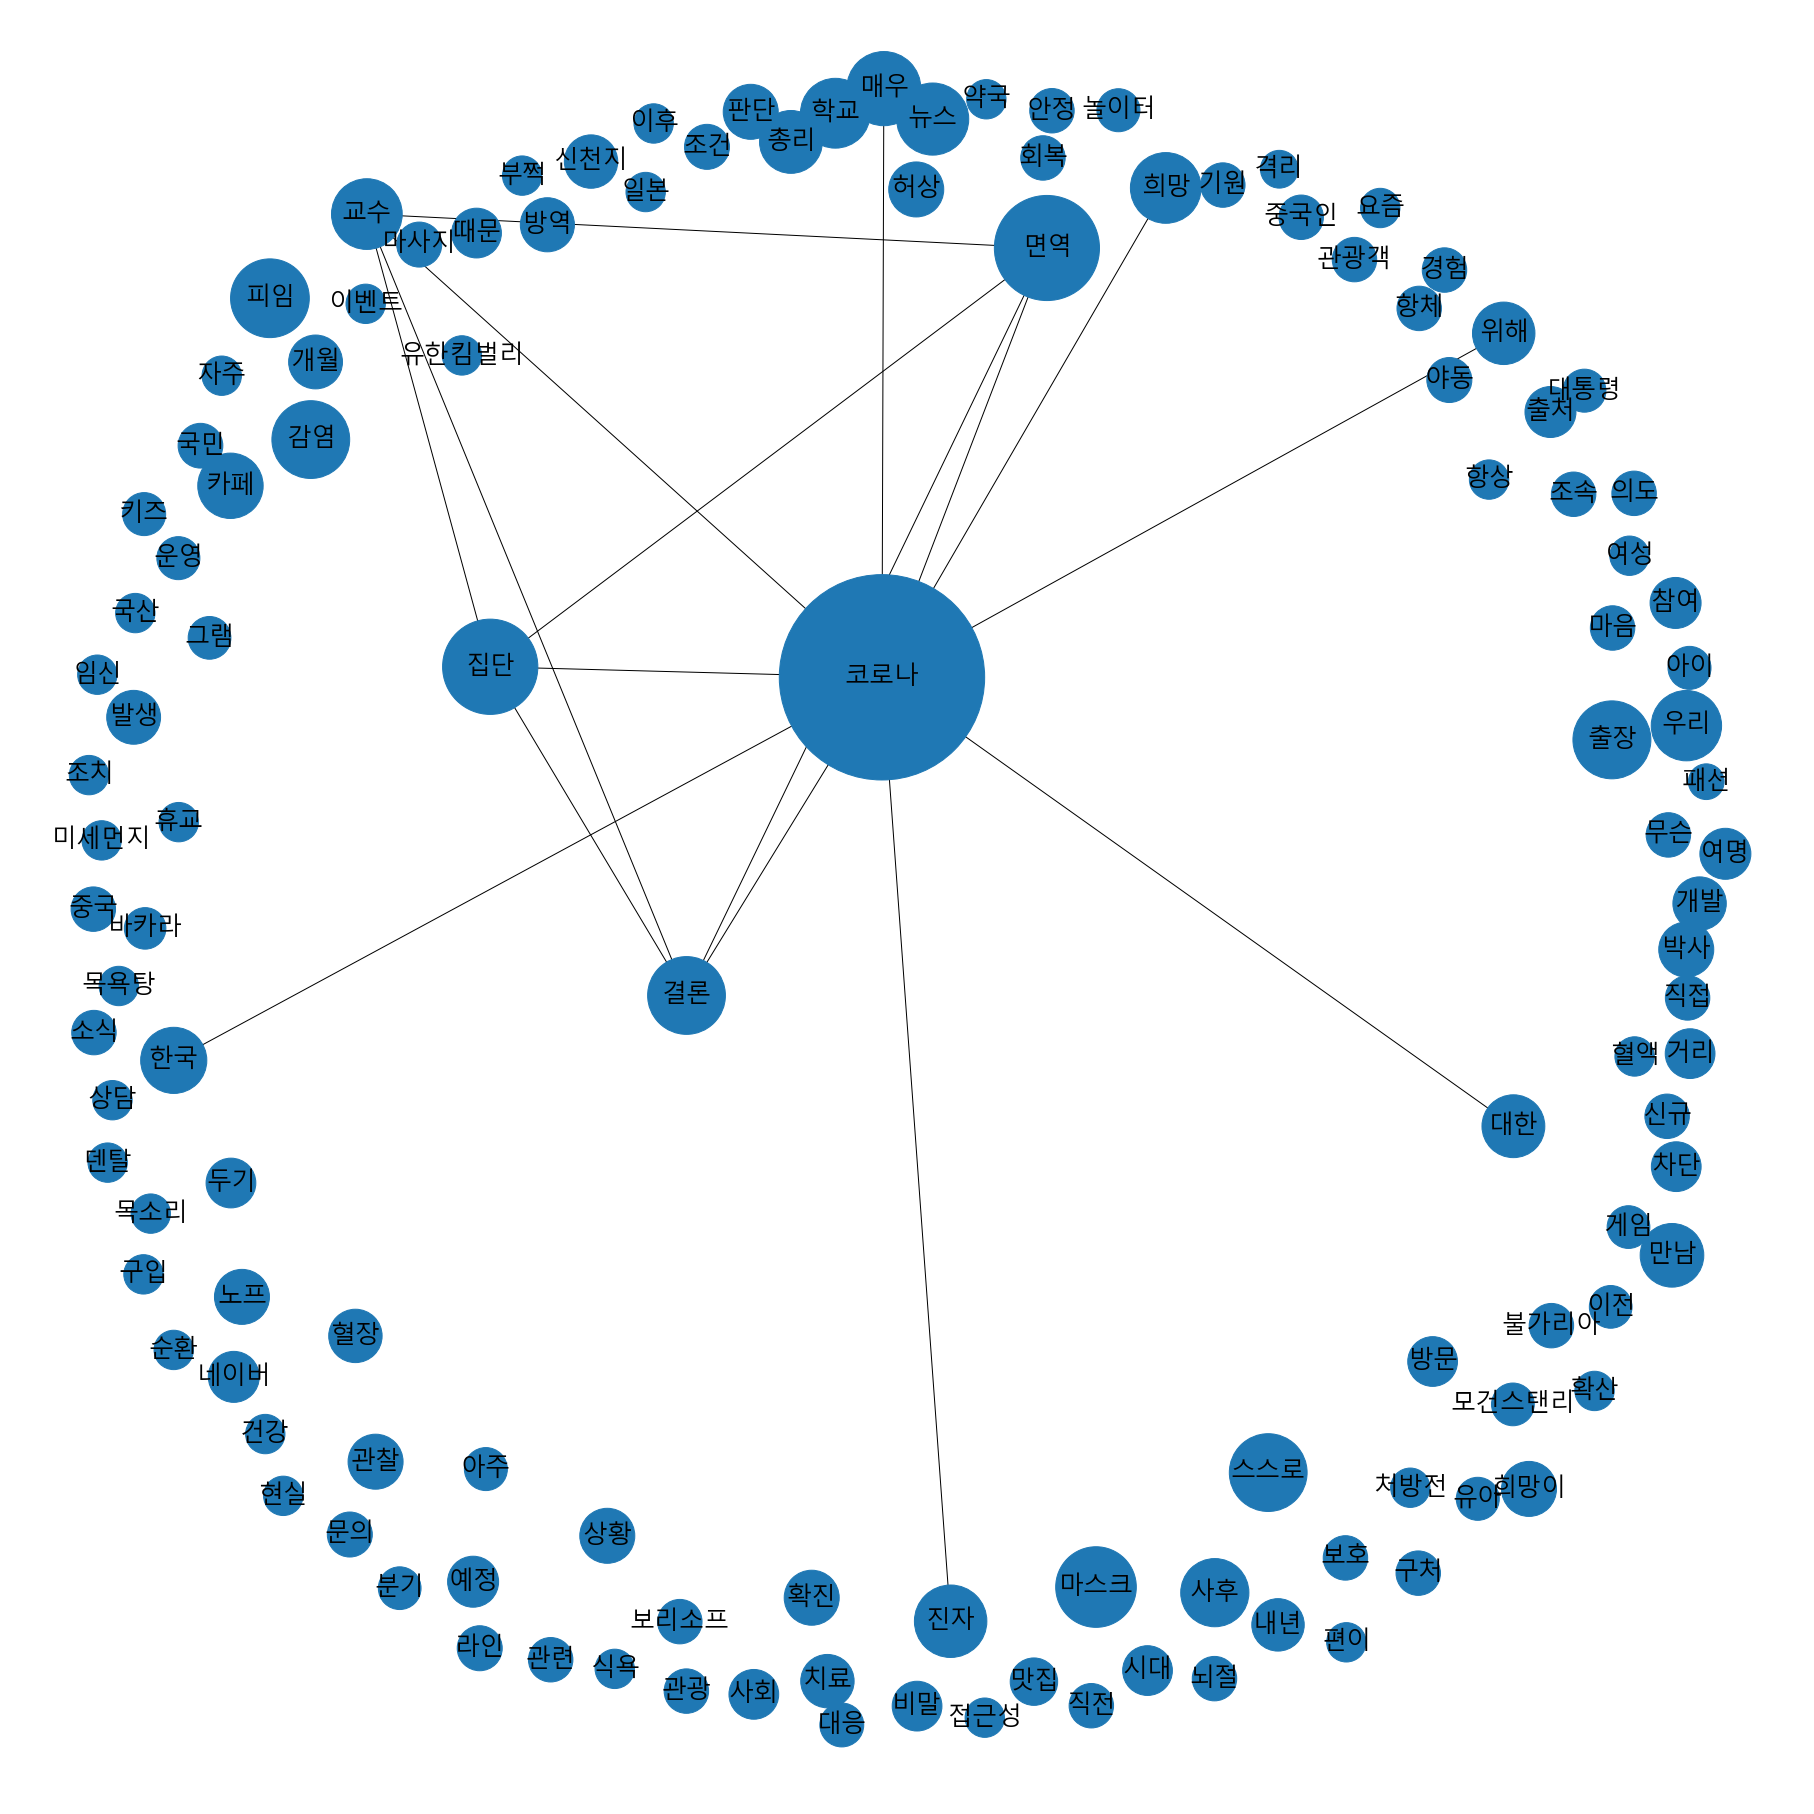

In [28]:
#pip install networkx
import networkx as nx
plt.figure(figsize=(25,25))

# networkx 그래프 객체를 생성합니다.
G = nx.Graph()

# node_df의 키워드 빈도수를 데이터로 하여, 네트워크 그래프의 ‘노드’ 역할을 하는 원을 생성합니다.
for index, row in node_df.iterrows():
    G.add_node(row['node'], nodesize=row['nodesize'])
    
# network_df의 연관 분석 데이터를 기반으로, 네트워크 그래프의 ‘관계’ 역할을 하는 선을 생성합니다.
for index, row in network_df.iterrows():
    G.add_weighted_edges_from([(row['source'], row['target'], row['support'])])
    
# 그래프 디자인과 관련된 파라미터를 설정합니다.
pos = nx.spring_layout(G, k=0.6, iterations=50)
sizes = [G.nodes[node]['nodesize']*25 for node in G]
nx.draw(G, pos=pos, node_size=sizes)

# Windows 사용자는 AppleGothic 대신,'Malgun Gothic'. 그 외 OS는 OS에서 한글을 지원하는 기본 폰트를 입력합니다.
nx.draw_networkx_labels(G, pos=pos, font_family='Malgun Gothic', font_size=25)

# 그래프를 출력합니다.
ax = plt.gca()
plt.show()